<a href="https://colab.research.google.com/github/bmakTMU/AER850/blob/main/AER850_Project_3_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install libraries

!pip install tensorflow-gpu
!pip install ultralytics opencv-python pillow matplotlib -q

from google.colab import drive
import os
import glob
import cv2
import numpy as np
import pathlib as Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "/content/drive/MyDrive/Project 3 Data"
motherboardimg_dir = os.path.join(root,"motherboard_image.JPEG")
YAML_dir = os.path.join(root, "data/data.yaml")

eval_dir = os.path.join(root, "data/evaluation")
test_dir = os.path.join(root, "data/test")
train_dir = os.path.join(root, "data/train")
valid_dir = os.path.join(root, "data/valid")

outputimg_dir = os.path.join(root, "outputs")
os.makedirs(outputimg_dir, exist_ok=True)

In [ ]:
def show_bgr_image(img_bgr, title="Image"):
    """Display a BGR (OpenCV) image with matplotlib."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

print(os.listdir('/content/drive/MyDrive/Project 3 Data/'))

['runs2', 'outputs2', 'eval_outputs2', 'motherboard_image.JPEG', '.DS_Store', 'prediction imgs', 'data', 'outputs1', 'eval_outputs1', 'runs1', 'outputs', 'runs']


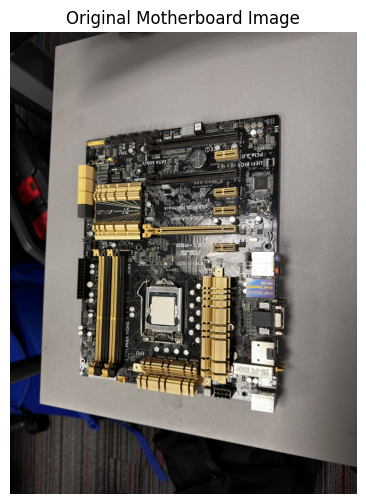

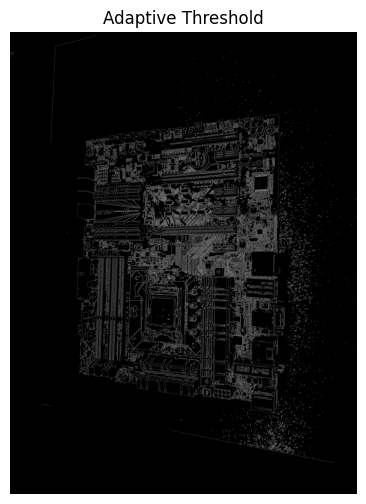

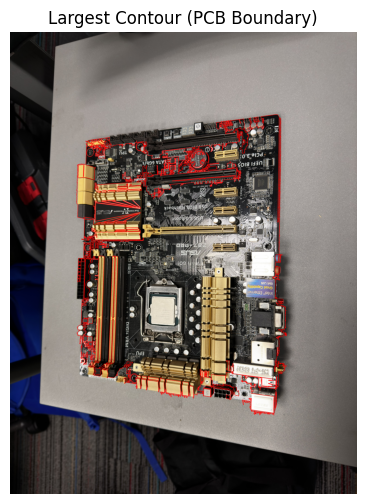

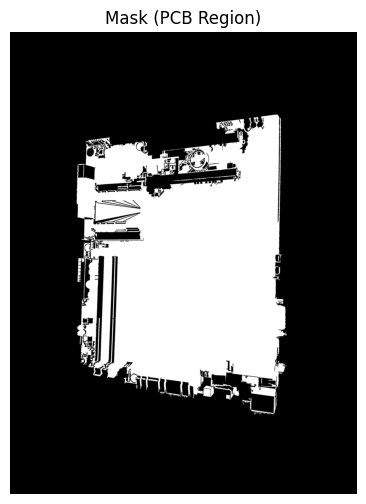

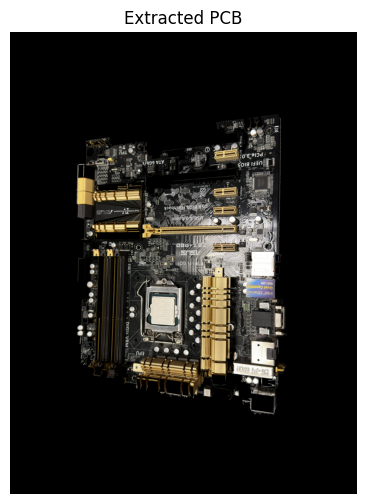

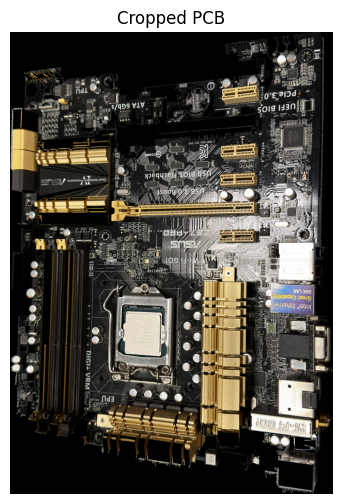

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os # Needed for os.path.join and os.makedirs

def show_bgr_image(img_bgr, title="Image"):
    """Display a BGR (OpenCV) image with matplotlib."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Oject masking

#load image
orig = cv2.imread(motherboardimg_dir)
if orig is None:
    raise FileNotFoundError(f"Could not read {motherboardimg_dir}. Check the path.")

show_bgr_image(orig, "Original Motherboard Image")

# grayscale and blur
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# edge detection
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 5)
edges = cv2.Canny(blur, threshold1=50, threshold2=150)

plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap="gray")
plt.title("Adaptive Threshold")
plt.axis("off")
plt.show()

edges = thresh.copy()

# find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not contours: # failsafe if variables are not tuned enough
    raise RuntimeError("No contours found – adjust Canny thresholds or preprocessing.")

largest_contour = max(contours, key=cv2.contourArea)

# Visualize contour on a copy
contour_img = orig.copy()
cv2.drawContours(contour_img, [largest_contour], -1, (0, 0, 255), 3)
show_bgr_image(contour_img, "Largest Contour (PCB Boundary)")

# contour mask
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.drawContours(mask, [largest_contour], -1, 255, thickness=-1)  # filled contour

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray")
plt.title("Mask (PCB Region)")
plt.axis("off")
plt.show()

# PWB extract
pcb_extracted = cv2.bitwise_and(orig, orig, mask=mask)
show_bgr_image(pcb_extracted, "Extracted PCB")
x, y, w, h = cv2.boundingRect(largest_contour)
pcb_cropped = pcb_extracted[y:y+h, x:x+w]
show_bgr_image(pcb_cropped, "Cropped PCB")

# Save image
cv2.imwrite(os.path.join(outputimg_dir, "edges.png"), edges)
cv2.imwrite(os.path.join(outputimg_dir, "mask.png"), mask)
cv2.imwrite(os.path.join(outputimg_dir, "pcb_extracted.png"), pcb_extracted)
cv2.imwrite(os.path.join(outputimg_dir, "pcb_cropped.png"), pcb_cropped)


In [ ]:

model = YOLO("yolo11n.pt")

EPOCHS = 50      # must remain below 200 as per instructions
BATCH_SIZE = 8   # original 16 cost too much VRAM, halved for performance
IMG_SIZE = 960    # >= 900 as per instructions

results = model.train(
    data=YAML_dir,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    name="pcb_yolo11n",
    project=os.path.join(root, "runs"),
    exist_ok=True
)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Project 3 Data/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolo11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

Evaluation images:
 - /content/drive/MyDrive/Project 3 Data/data/evaluation/arduno.jpg
 - /content/drive/MyDrive/Project 3 Data/data/evaluation/rasppi.jpg
 - /content/drive/MyDrive/Project 3 Data/data/evaluation/ardmega.jpg

Running detection on: /content/drive/MyDrive/Project 3 Data/data/evaluation/arduno.jpg

image 1/1 /content/drive/MyDrive/Project 3 Data/data/evaluation/arduno.jpg: 672x960 1 Button, 17 Capacitors, 7 Connectors, 5 Electrolytic Capacitors, 6 ICs, 2 Leds, 5 Resistors, 1 Transistor, 62.7ms
Speed: 4.1ms preprocess, 62.7ms inference, 1.6ms postprocess per image at shape (1, 3, 672, 960)
Results saved to /content/drive/MyDrive/Project 3 Data/eval_outputs/pcb_eval


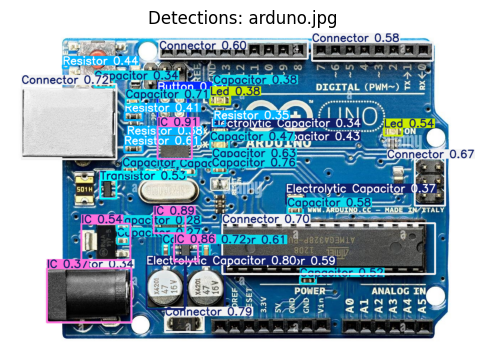

Detected classes (indices): [          5           5           5           4           2           1           1           1           2           1           2           2           1           1          10           1           2           4           1           2           7           5          12           1           1           1
           1          10           5           4          10           7          10           1           0           4           5           1          10           2           4           1           1           1]
Confidence scores: [    0.91418     0.88713     0.86225     0.79692     0.78844     0.75567     0.73689     0.71734     0.71661     0.71153     0.70385     0.66837      0.6296     0.61368      0.6096     0.60666     0.59807     0.58824     0.58277     0.57973     0.53619      0.5351     0.52881     0.52302     0.51562     0.50632
     0.46724     0.44187     0.43927     0.42803       0.409     0.38475     0.38182      0.3757     0.37492 

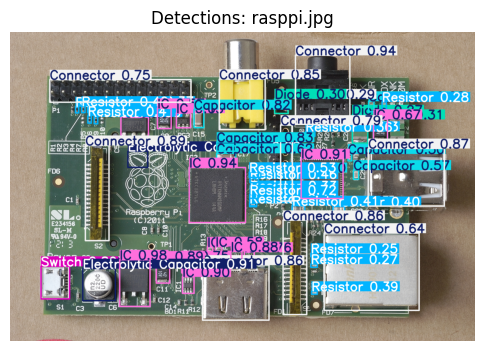

Detected classes (indices): [          5           5           2           4           5           5           5           2          11           5           2           2           2           2           1           1           2           5           2           5          10           5           2           5           1           5
           5           1          10          10          10           2          10          10          10          10          10          10          10          10          10          10          10          10           2           3           1           1          10           3           2           5
           4          10           1          10          10           3          10           5          10]
Confidence scores: [    0.97955     0.94322     0.94306     0.91381      0.9105     0.89593     0.89087     0.88812     0.88581     0.87718     0.87179     0.86115     0.86109     0.84742     0.83453     0.81689     0.78655     0.75612 

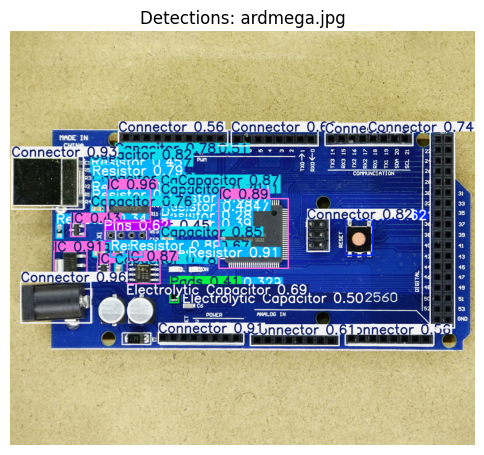

Detected classes (indices): [          5           2           2           2          10           5           5          10          10           1           5           1           1           2          10           1           1           1           1           1          10           2          10          10           4           1
           2           2           5           9           0           2           2           2           1          10           1          10           4          10          10           1          10          10           2           5           1           8          10          10          10          10
          10           1           1]
Confidence scores: [    0.96266     0.95611     0.92617     0.91048     0.90612     0.90512     0.89436     0.89053     0.88487     0.87392     0.86692     0.85306     0.81578     0.81517     0.78898     0.78695     0.78333     0.77838     0.76437     0.76107     0.75393     0.74093      0.7346     0.69178 

In [ ]:
# evaluation

eval_image_paths = [
    os.path.join(eval_dir, fname)
    for fname in os.listdir(eval_dir)
    if fname.lower().endswith((".jpg", ".jpeg", ".png"))
]

print("Evaluation images:")
for p in eval_image_paths:
    print(" -", p)
#prediction
EVAL_OUTPUT_DIR = os.path.join(root, "eval_outputs")
os.makedirs(EVAL_OUTPUT_DIR, exist_ok=True)

for img_path in eval_image_paths:
    print(f"\nRunning detection on: {img_path}")
    preds = model.predict(
        source=img_path,
        imgsz=IMG_SIZE,
        conf=0.25,
        save=True,
        project=EVAL_OUTPUT_DIR,
        name="pcb_eval",
        exist_ok=True
    )

    # Display the first result inline
    result = preds[0]
    # result.plot() returns an array (BGR)
    plotted = result.plot()
    show_bgr_image(plotted, title=f"Detections: {os.path.basename(img_path)}")

    print("Detected classes (indices):", result.boxes.cls.cpu().numpy())
    print("Confidence scores:", result.boxes.conf.cpu().numpy())

print("\nEvaluation complete. Check the 'eval_outputs/pcb_eval' folder in Drive for saved images.")